In [1]:
# Pandas and Numpy for data structures and util fucntions
import scipy as sp
import numpy as np
import pandas as pd
from numpy.random import rand
pd.options.display.max_colwidth = 600

# Scikit Imports
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split

In [3]:
from google.colab import files
uploaded = files.upload()

Saving cnn_utils.py to cnn_utils.py
Saving model_evaluation_utils.py to model_evaluation_utils.py


In [4]:
import cnn_utils as utils
from model_evaluation_utils import get_metrics

In [5]:

# Matplot Imports
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

In [6]:
plt.rcParams.update(params)
%matplotlib inline

In [7]:
# pandas display data frames as tables
from IPython.display import display, HTML

In [8]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
from tensorflow import keras

In [15]:
import cnn_utils as utils
from model_evaluation_utils import get_metrics

In [12]:
import tensorflow as tf
from keras import callbacks
from keras import optimizers
from keras.datasets import cifar10
#from keras.engine import Model
from keras.applications import vgg16 as vgg
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
#from keras.utils import np_utils

In [13]:
BATCH_SIZE = 32
EPOCHS = 40
NUM_CLASSES = 10
LEARNING_RATE = 1e-4
MOMENTUM = 0.9

In [17]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


In [18]:
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.15,
                                                  stratify=np.array(y_train),
                                                  random_state=42)

In [21]:
pip install np_utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56441 sha256=37a6ad5d1d0b9ce1790b1470bfe765817612d524501e24bd3915232b7934d8c3
  Stored in directory: /root/.cache/pip/wheels/b6/c7/50/2307607f44366dd021209f660045f8d51cb976514d30be7cc7
Successfully built np_utils


In [25]:
import np_utils
from keras.utils import to_categorical

In [31]:
from tensorflow.keras.utils import to_categorical

In [33]:
Y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
Y_val = keras.utils.to_categorical(y_val, NUM_CLASSES)
Y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)

In [36]:
from PIL import Image

In [37]:
from skimage.transform import resize
from skimage import data
image = data.camera()

In [40]:
from skimage import transform

In [42]:
X_train = np.array([transform.resize(x,
                                     (48, 48)) for x in X_train])
X_val = np.array([transform.resize(x,
                                   (48, 48)) for x in X_val])
X_test = np.array([transform.resize(x,
                                    (48, 48)) for x in X_test])

In [43]:
base_model = vgg.VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(48, 48, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [44]:
# Extract the last layer from third block of vgg16 model
last = base_model.get_layer('block3_pool').output

In [46]:
from tensorflow.keras import Model

In [47]:
# Add classification layers on top of it
x = GlobalAveragePooling2D()(last)
x= BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.6)(x)
pred = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(base_model.input, pred)

In [48]:
for layer in base_model.layers:
     layer.trainable = False

In [49]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
              metrics=['accuracy'])

In [50]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [51]:
# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=False)

In [52]:
train_datagen.fit(X_train)
train_generator = train_datagen.flow(X_train,
                                     Y_train,
                                     batch_size=BATCH_SIZE)

In [53]:
val_datagen = ImageDataGenerator(rescale=1. / 255,
    horizontal_flip=False)

val_datagen.fit(X_val)
val_generator = val_datagen.flow(X_val,
                                 Y_val,
                                 batch_size=BATCH_SIZE)

In [54]:
train_steps_per_epoch = X_train.shape[0] // BATCH_SIZE
val_steps_per_epoch = X_val.shape[0] // BATCH_SIZE

history = model.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=EPOCHS,
                              verbose=1)

Epoch 1/40
1328/1328 [==============================] - 20s 10ms/step - loss: 0.2366 - accuracy: 0.4647 - val_loss: 0.1913 - val_accuracy: 0.5736
Epoch 2/40
1328/1328 [==============================] - 13s 10ms/step - loss: 0.1974 - accuracy: 0.5633 - val_loss: 0.1783 - val_accuracy: 0.6028
Epoch 3/40
1328/1328 [==============================] - 12s 9ms/step - loss: 0.1853 - accuracy: 0.5978 - val_loss: 0.1704 - val_accuracy: 0.6243
Epoch 4/40
1328/1328 [==============================] - 13s 10ms/step - loss: 0.1774 - accuracy: 0.6186 - val_loss: 0.1630 - val_accuracy: 0.6437
Epoch 5/40
1328/1328 [==============================] - 13s 10ms/step - loss: 0.1710 - accuracy: 0.6330 - val_loss: 0.1620 - val_accuracy: 0.6400
Epoch 6/40
1328/1328 [==============================] - 13s 9ms/step - loss: 0.1658 - accuracy: 0.6448 - val_loss: 0.1608 - val_accuracy: 0.6442
Epoch 7/40
1328/1328 [==============================] - 14s 10ms/step - loss: 0.1607 - accuracy: 0.6586 - val_loss: 0.1562 - v

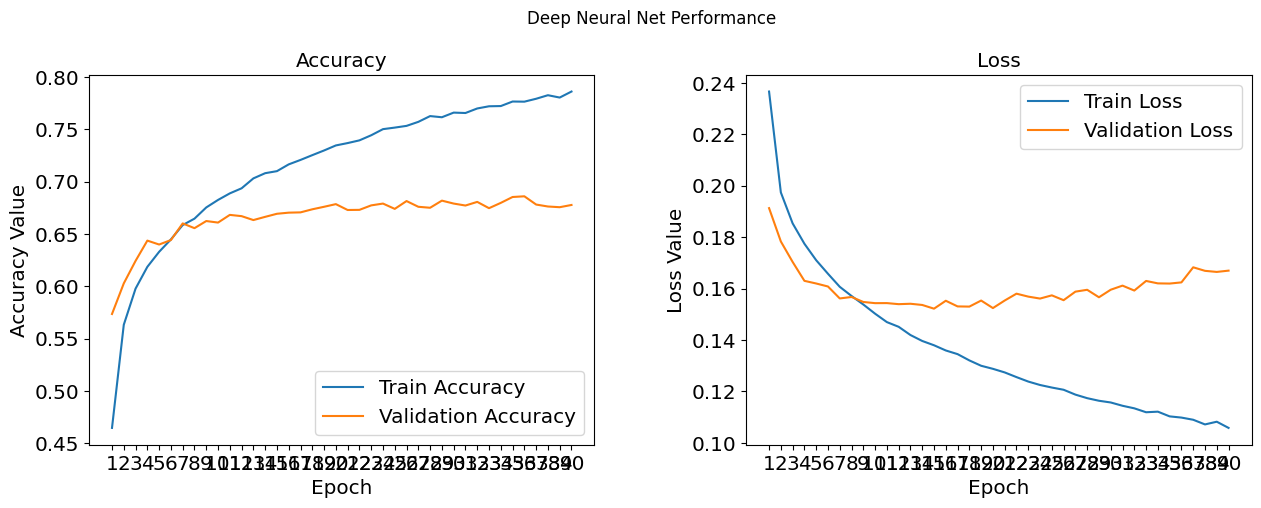

In [57]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
t = f.suptitle('Deep Neural Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,EPOCHS+1))
ax1.plot(epochs, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [58]:
predictions = model.predict(X_test/255.)

313/313 [==============================] - 2s 7ms/step


In [59]:
test_labels = list(y_test.squeeze())
predictions = list(predictions.argmax(axis=1))

In [60]:
get_metrics(true_labels=y_test,
                predicted_labels=predictions)

Accuracy: 0.6764
Precision: 0.6774
Recall: 0.6764
F1 Score: 0.6742


In [69]:
classes = {0:'airplane',
             1:'automobile',
             2:'bird',
             3:'cat',
             4:'deer',
             5:'dog',
             6:'frog',
             7:'horse',
             8:'ship',
             9:'truck'}

In [66]:
def plot_image(i,predictions_array,true_label,img):
  predictions_array,true_label,img=predictions_array,true_label[i],img[i]
  plt.grid[False]
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img,cmap=plt.cm.binary)
  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color ='blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(label_dict[predicted_label],100* np.max(predictions_array),label_dict[true_label]),color=color)

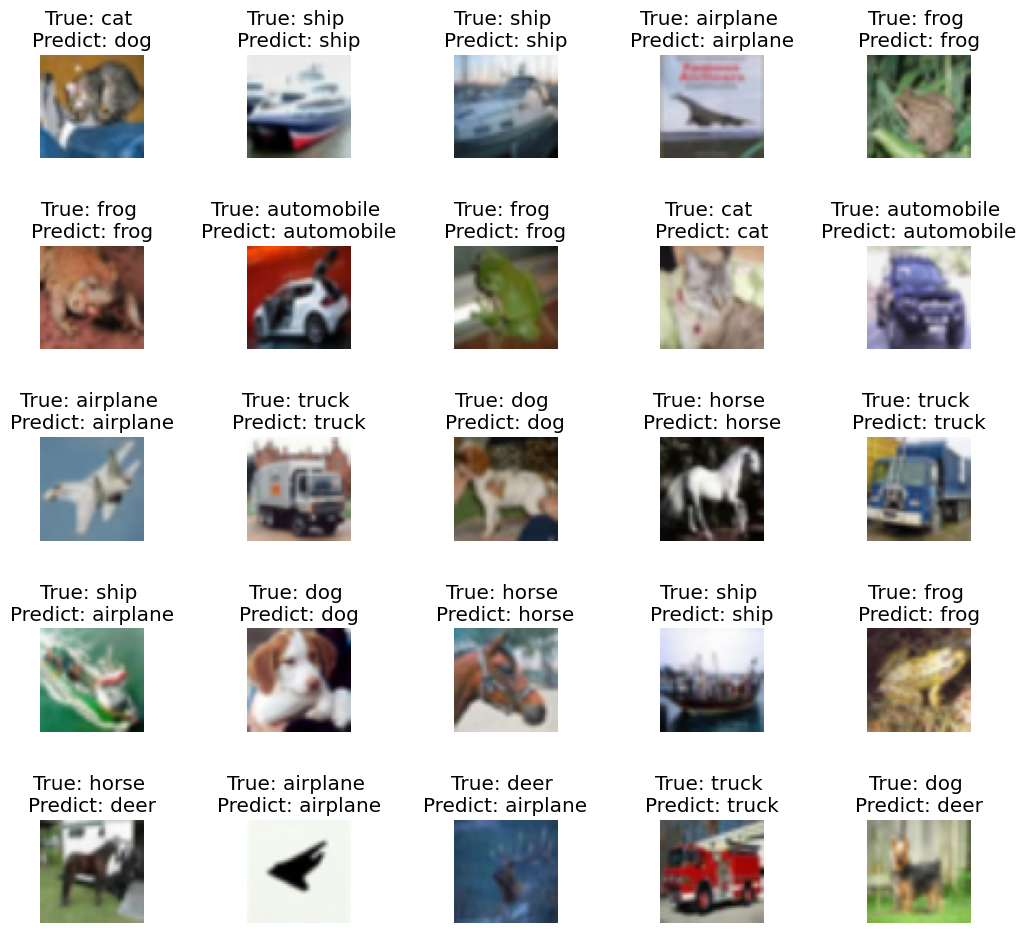

In [70]:
R=5
C=5
fig,axes = plt.subplots(R,C, figsize=(12,12))
axes=axes.ravel()

for i in np.arange(0,R*C):
  axes[i].imshow(X_test[i])
  axes[i].set_title("True: %s \nPredict: %s" % (classes[np.argmax(Y_test[i])],
                                                classes[predictions[i]]))
  axes[i].axis('off')
  plt.subplots_adjust(wspace=1)